In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import fastai
from fastai.vision import *

from torchvision import models
from visualization.modules import LayeredModule, get_nested_layers
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
path = Path("/home/jupyter/fai-berlin-faces/cropped/")
#verify_images(path, recurse=True)


In [4]:
def isFemale(path): return bool(int(path.name.split('_')[1]))

def get_gender(path):
   # print(path, "path here")
    return "female" if isFemale(path) else "male"


In [5]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(get_gender) \
            .databunch() \
            .normalize(imagenet_stats) )

In [6]:
learner = cnn_learner(data, models.vgg19, metrics=[accuracy])

In [7]:
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): C

In [8]:
[t for t, _ in get_nested_layers(learner.model)]

['0-0-conv-0',
 '0-0-relu-0',
 '0-0-conv-1',
 '0-0-relu-1',
 '0-0-pool-0',
 '0-0-conv-2',
 '0-0-relu-2',
 '0-0-conv-3',
 '0-0-relu-3',
 '0-0-pool-1',
 '0-0-conv-4',
 '0-0-relu-4',
 '0-0-conv-5',
 '0-0-relu-5',
 '0-0-conv-6',
 '0-0-relu-6',
 '0-0-conv-7',
 '0-0-relu-7',
 '0-0-pool-2',
 '0-0-conv-8',
 '0-0-relu-8',
 '0-0-conv-9',
 '0-0-relu-9',
 '0-0-conv-10',
 '0-0-relu-10',
 '0-0-conv-11',
 '0-0-relu-11',
 '0-0-pool-3',
 '0-0-conv-12',
 '0-0-relu-12',
 '0-0-conv-13',
 '0-0-relu-13',
 '0-0-conv-14',
 '0-0-relu-14',
 '0-0-conv-15',
 '0-0-relu-15',
 '0-0-pool-4',
 '1-AdaptiveConcatPool2d-0',
 '1-Flatten-0',
 '1-BatchNorm1d-0',
 '1-dropout-0',
 '1-linear-0',
 '1-relu-0',
 '1-BatchNorm1d-1',
 '1-dropout-1',
 '1-linear-1']

In [38]:
learner.unfreeze()

In [46]:
a = LayeredModule(get_nested_layers(learner.model), hooked_layer_keys=["0-0-relu-15"])

In [47]:
women = learner.data.x[33].data
women.requires_grad_()
women = women.cuda()
women[None].shape


torch.Size([1, 3, 200, 200])

In [51]:
nl = NetLens(a, women[None], 0)

In [52]:
nl.generate_cam("0-0-relu-15")

tensor([[0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        [0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        [0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [50]:
nl.show_guided_gradcam("0-0-relu-15")

KeyError: '1-relu-0'

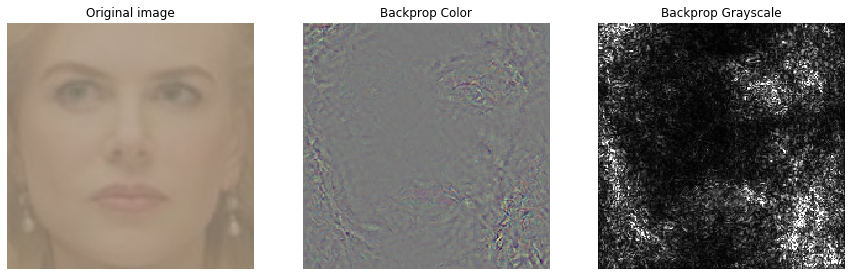

In [53]:
nl.show_gradient_backprop()

In [54]:
nl.show_gradient_backprop(guided=True)

KeyError: '1-relu-0'

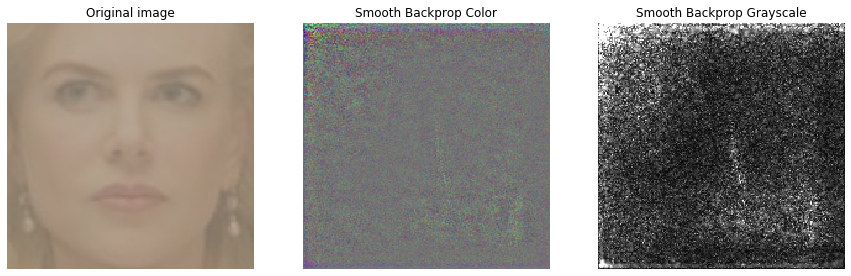

In [55]:
nl.show_smooth_gradient()

In [18]:
learner.freeze()

In [19]:
#[(name, p.requires_grad) for name, p in learner.model.named_parameters()]

In [20]:
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.719412,0.529086,0.793862,01:01
1,0.542308,0.433787,0.812276,00:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


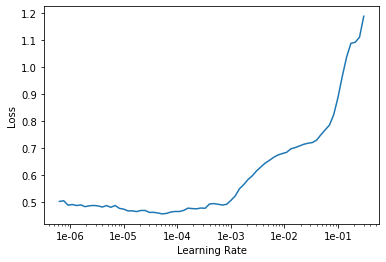

In [56]:
learner.lr_find()
learner.recorder.plot()

In [57]:
learner.fit_one_cycle(2,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.578217,1.372139,0.672634,02:23
1,0.530705,0.392654,0.820460,02:24


In [26]:
learner.unfreeze()
a = LayeredModule(get_nested_layers(learner.model))
nl = NetLens(a, women[None], 0)
nl.generate_cam("0-0-relu-15")

tensor([[0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        [0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        [0.3054, 0.3054, 0.3054,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

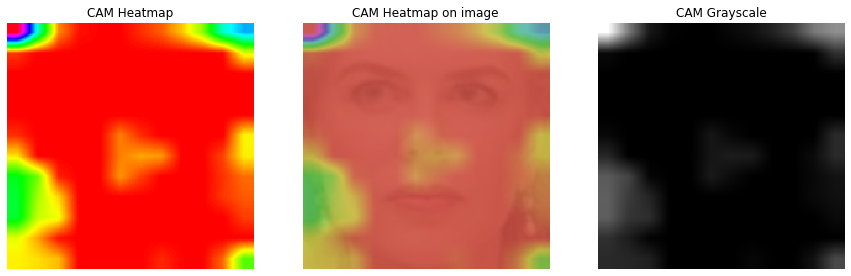

In [27]:
nl.show_gradcam("0-0-relu-14")

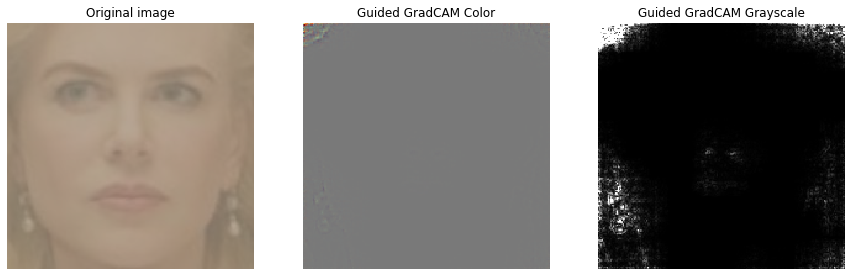

In [28]:
nl.show_guided_gradcam("0-0-relu-14")

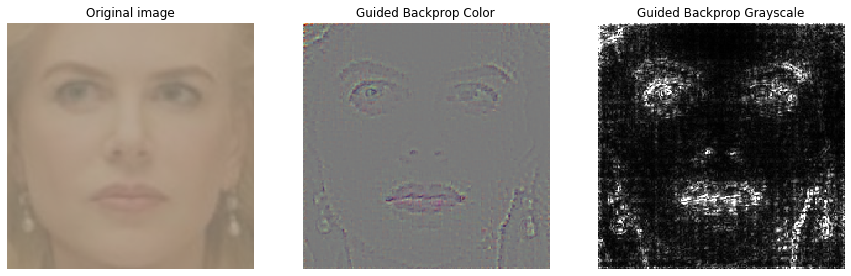

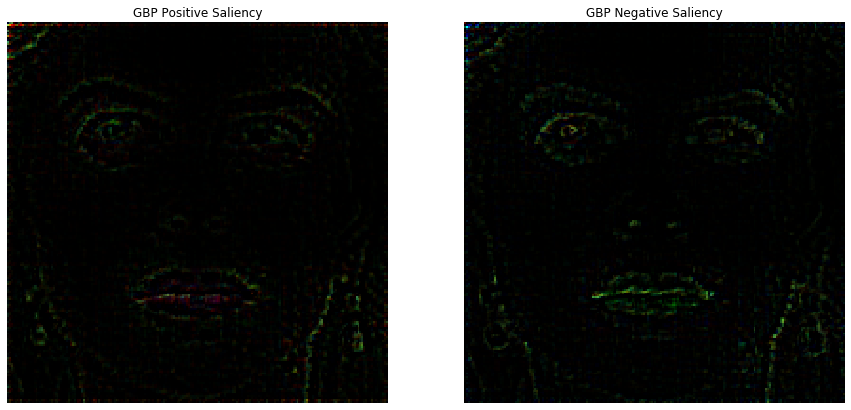

In [29]:
nl.show_gradient_backprop(guided=True)

In [25]:
learner.save('vgg_face_1')

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
from fastai.utils.mem import * 
gpu_mem_get_all()
free = gpu_mem_get_free_no_cache()
free